In [1]:
import math
import collections
import pickle
import random
import scipy
import json

from matplotlib import pyplot as plt

import GPy
import numpy as np
import pandas as pd
from tqdm import tqdm
# from DataPrep_V2 import data_prep, exp_data_collection, get_test_data

# from Kernel import MixtureViaSumAndProduct, CategoryOverlapKernel
from methods.InitialData_Gen import initialize
# from methods.AcquisitionFunctions import EI, PI, UCB, AcquisitionOnSubspace
# from SamplingCategorical import compute_prob_dist_and_draw_hts
from methods.UpdateCategoricalWeight import compute_reward_for_all_cat_variable, update_weights_for_all_cat_var
# from methods.optimization import sample_then_minimize

from methods.AskTell import ask_tell
from scipy import linalg
# from numpy.linalg import LinAlgError

from scipy.optimize import minimize

from typing import Union, Tuple
from paramz.transformations import Logexp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

1. C - List of number of categroies corresponding to each categorical variable
2. Nc - Number of categorical variables
3. Nx - Continuous variables
4. h - categorical
5. x - continuous
6. z - [h, x]

7. nDim - Nc + Nx
8. bounds - Lower and Upper bounds of both Catergorical variables and continuous variables

9. n_iter - Number of iterations to run the algorithm
10. initN - Number of intial data points
11. batch_size (b) - Number of experiments to be generated in each iteration

12. acq_type - Acquisition Type
13. Meas_Noise - Measurement Noise in the target 
14. Trade-off : Explorarion exploitation balance

In [2]:
from methods.AskTell import get_kernel, Scaling_data

### 1. Defining parameters of the system

In [3]:
bounds = [  {'name': 'XVIVO', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'DMEM', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'AR5', 'type': 'continuous', 'domain': (0, 1)},
         {'name': 'RPMI', 'type': 'continuous', 'domain': (0, 1)},]

constraints = [{'name': 'constr_1', 'constraint': 'x[:,0] + x[:,1] + x[:,2] + x[:,3]-1.0001'},
              {'name': 'constr_2', 'constraint': '-x[:,0] - x[:,1] - x[:,2] - x[:,3]+0.999'}] #for design space

constraint_function = scipy.optimize.LinearConstraint([[1, 1,1, 1]], [1], [1]) #For optimization function formulation

Nx = len(bounds)
initN = 12
Nc = 0
Niter = 1
batch_size = 3
approach_type = 'Co'
prob_type = 'Constrained'


data_param = {'Nx': Nx, 'Nc': Nc, 'nDim': Nc+Nx, 'bounds': bounds,'C': [],
              'Constrains': constraints, 'Constrains_function': constraint_function,
              'approach_type': approach_type, 'Meas_Noise': 0.3, 'trade_off': 3,
              'prob_type': prob_type, 'initN': initN, 'Meas_Noise': 0.1, 'trade_off': 3, 'batch_size': batch_size}

In [4]:
#read in the data file with all experiments planned until this iteration
design= pd.read_excel("./dummy_data/PBMC_Design_Result.xlsx").values[:,2:6]

# read in the data file containing the corresponding target values
result =pd.read_excel("./dummy_data/PBMC_Design_Result.xlsx")['Average Viability [%]'].values.reshape(-1,1)


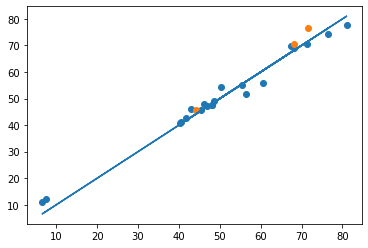

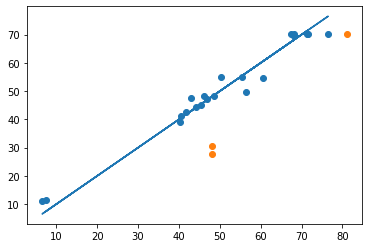

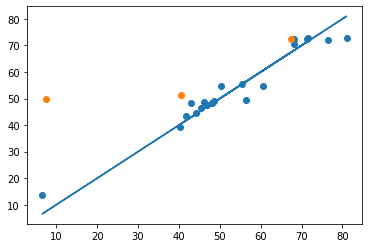

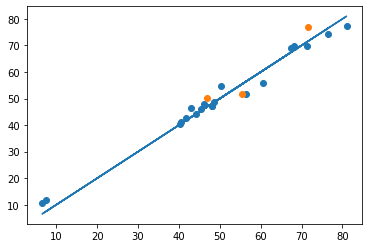

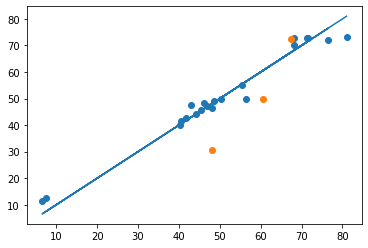

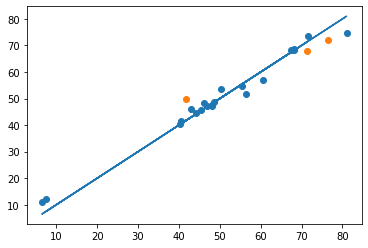

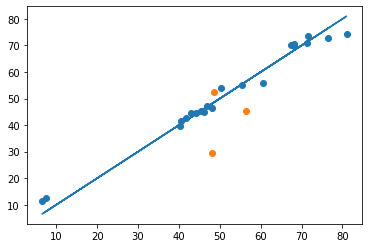

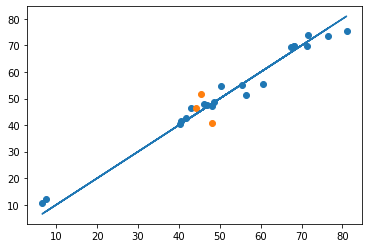

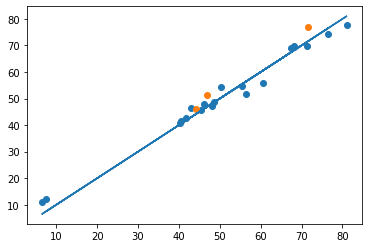

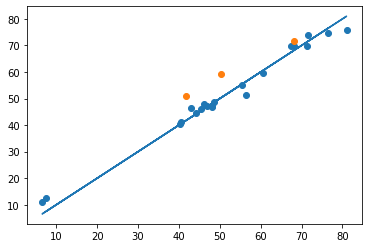

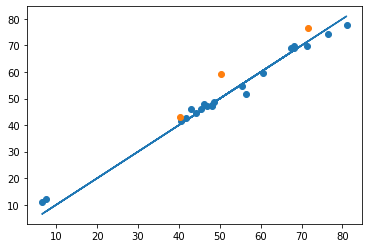

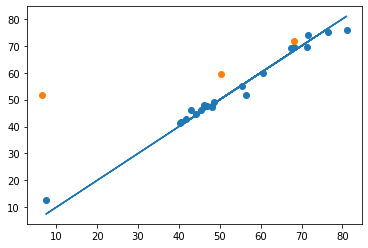

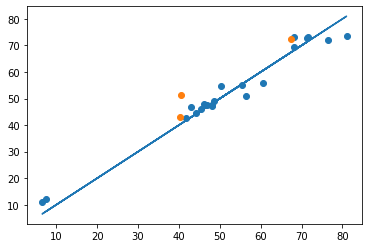

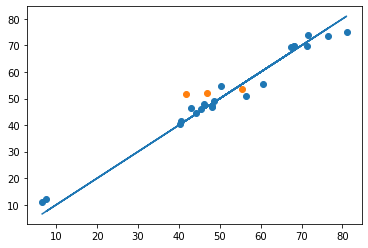

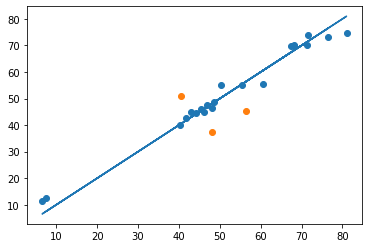

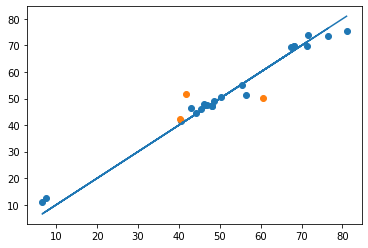

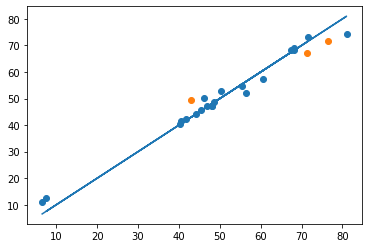

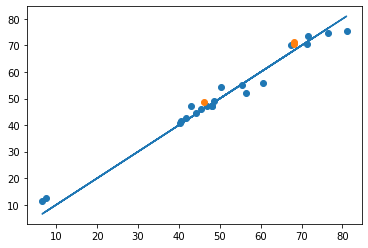

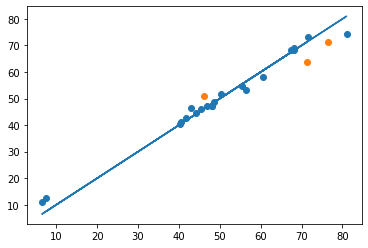

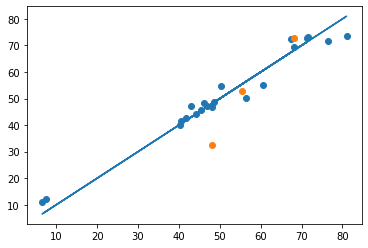

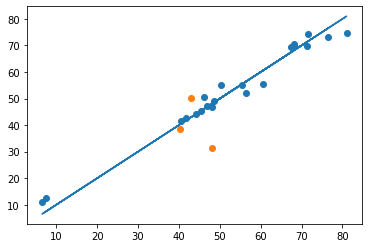

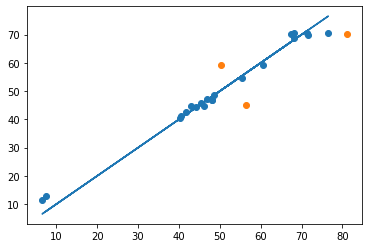

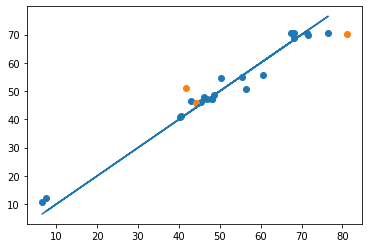

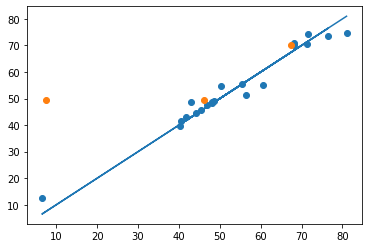

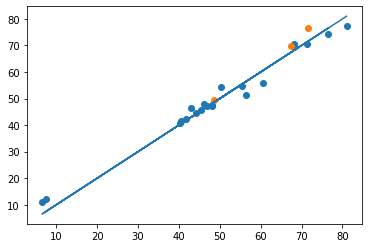

In [5]:
n_samp = 25
RMSEF_32 = np.zeros((n_samp, 1))
RMSEP_32 = np.zeros((n_samp, 1))

for i in range(n_samp):     
    cont_kernel_name = 'Matern32'
    kernel = get_kernel(data_param, cont_kernel_name)
    X_train, X_test, y_train, y_test = train_test_split(design, result, test_size=0.1, random_state=i*100)
    mu_x, std_x, mu_y, std_y, data_norm, result_norm = Scaling_data(X_train, y_train)

    data_norm_ts = (X_test - mu_x)/std_x
    
    gp = GPy.models.GPRegression(data_norm, result_norm, kernel)
    gp.optimize(max_iters = 10000)
    y_pred_tr = np.mean(gp.posterior_samples_f(data_norm, 10000), 2)
    y_pred_ts = np.mean(gp.posterior_samples_f(data_norm_ts, 10000), 2)

    y_pred_tr_unsc = y_pred_tr * std_y + mu_y
    y_pred_ts_unsc = y_pred_ts * std_y + mu_y
    
    RMSEF_32[i,0] = np.sqrt(MSE(y_train,y_pred_tr_unsc))
    RMSEP_32[i,0] = np.sqrt(MSE(y_test,y_pred_ts_unsc))
    
    plt.figure()
    plt.scatter(y_train, y_pred_tr_unsc)
    plt.scatter(y_test,y_pred_ts_unsc)
    plt.plot(y_train, y_train)

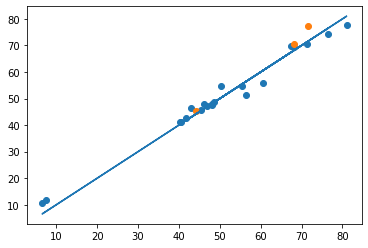

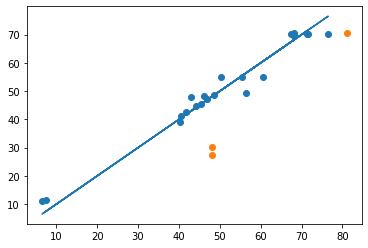

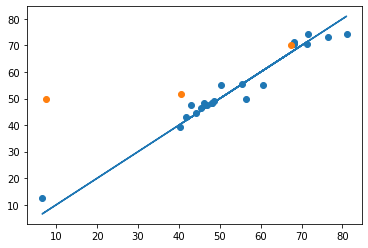

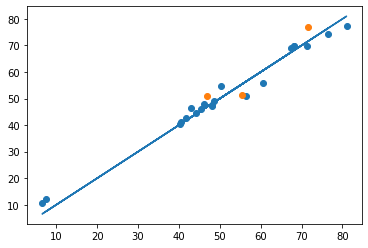

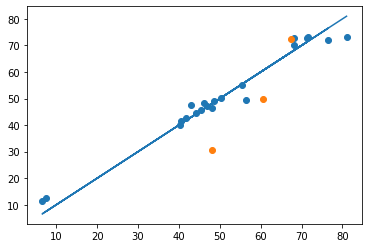

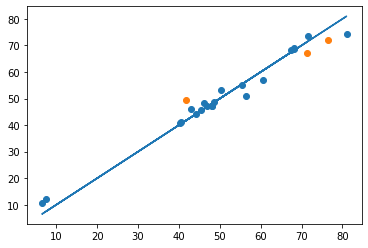

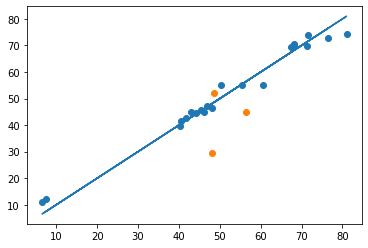

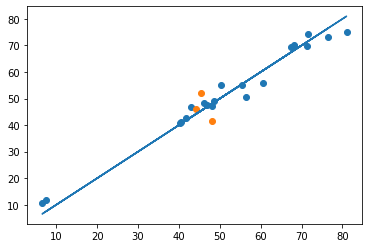

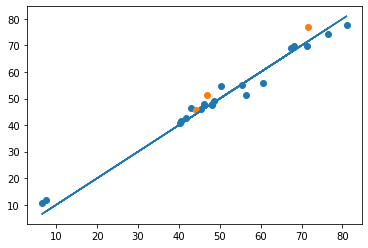

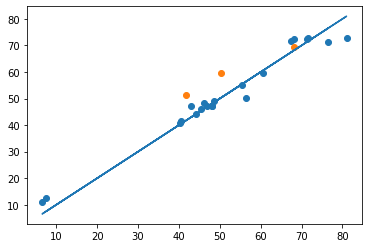

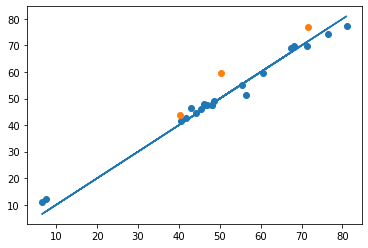

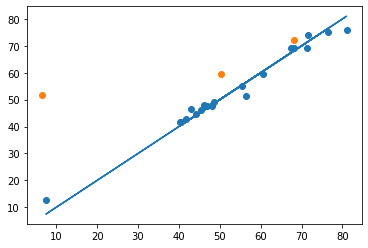

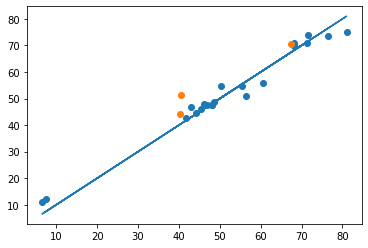

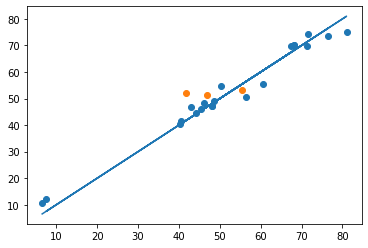

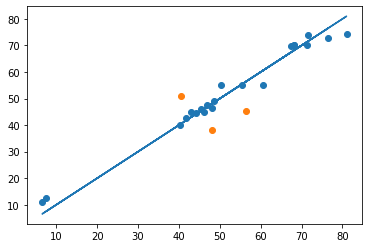

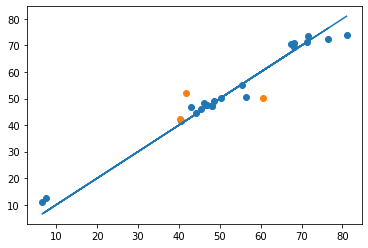

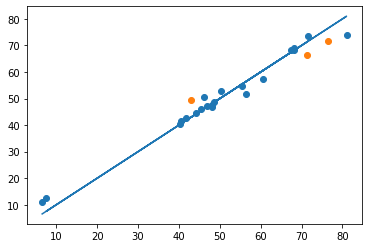

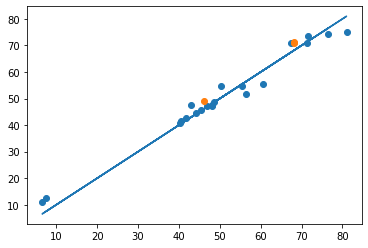

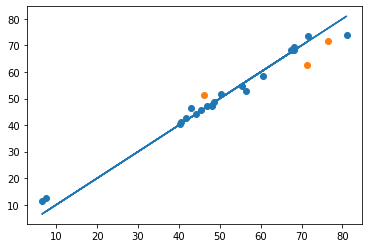

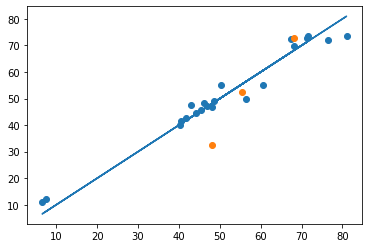

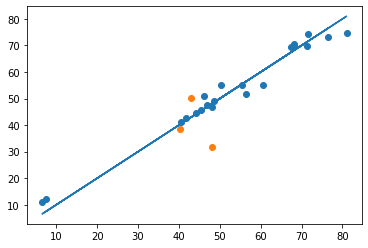

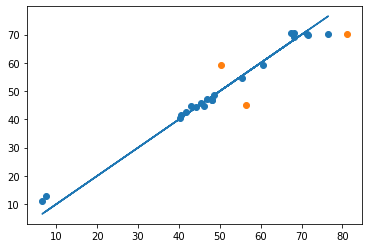

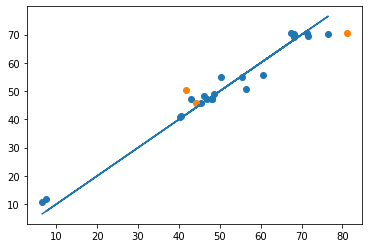

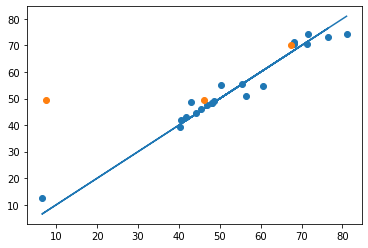

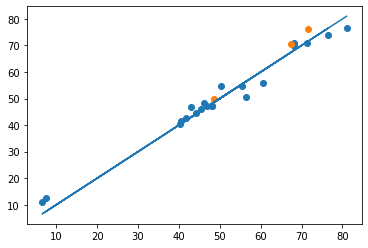

In [6]:
n_samp = 25
RMSEF_52 = np.zeros((n_samp, 1))
RMSEP_52 = np.zeros((n_samp, 1))

for i in range(n_samp):     
    cont_kernel_name = 'Matern52'
    kernel = get_kernel(data_param, cont_kernel_name)
    X_train, X_test, y_train, y_test = train_test_split(design, result, test_size=0.1, random_state=i*100)
    mu_x, std_x, mu_y, std_y, data_norm, result_norm = Scaling_data(X_train, y_train)

    data_norm_ts = (X_test - mu_x)/std_x
    
    gp = GPy.models.GPRegression(data_norm, result_norm, kernel)
    gp.optimize(max_iters = 10000)
    y_pred_tr = np.mean(gp.posterior_samples_f(data_norm, 10000), 2)
    y_pred_ts = np.mean(gp.posterior_samples_f(data_norm_ts, 10000), 2)

    y_pred_tr_unsc = y_pred_tr * std_y + mu_y
    y_pred_ts_unsc = y_pred_ts * std_y + mu_y
    
    RMSEF_52[i,0] = np.sqrt(MSE(y_train,y_pred_tr_unsc))
    RMSEP_52[i,0] = np.sqrt(MSE(y_test,y_pred_ts_unsc))
    
    plt.figure()
    plt.scatter(y_train, y_pred_tr_unsc)
    plt.scatter(y_test,y_pred_ts_unsc)
    plt.plot(y_train, y_train)

In [7]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

<Figure size 432x288 with 0 Axes>

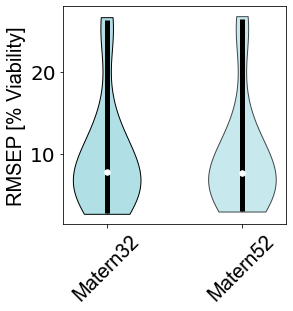

In [8]:
plt_data = np.concatenate((RMSEP_32, RMSEP_52), axis = 1)
plt.figure()
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (4, 4)
f, ax = plt.subplots(1, 1)
parts = plt.violinplot(plt_data, showmeans=False, showmedians=False,
        showextrema=False)

cnt = 0
alpha_list = [1, 0.7, 0.5, 0.3]
for pc in parts['bodies']:
    print(pc)
    pc.set_facecolor('powderblue')
    pc.set_edgecolor('black')

    pc.set_alpha(alpha_list[cnt])
    cnt = cnt+1


quartile1, medians, quartile3 = np.percentile(np.transpose(plt_data), [1, 50, 99], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(plt_data, quartile1, quartile3)])

whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
ax.set_ylabel("RMSEP [% Viability]", **hfont)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Matern32', 'Matern52'], rotation = 45,**hfont)
plt.savefig("RMSEP_32vs52.pdf", dpi = 600, bbox_inches = "tight")

<Figure size 288x288 with 0 Axes>

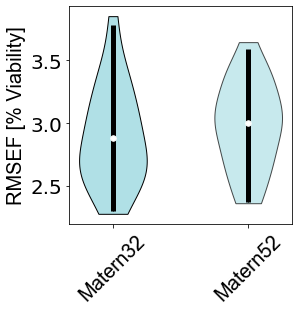

In [9]:
plt_data = np.concatenate((RMSEF_32, RMSEF_52), axis = 1)
plt.figure()
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (4, 4)
f, ax = plt.subplots(1, 1)
parts = plt.violinplot(plt_data, showmeans=False, showmedians=False,
        showextrema=False)

cnt = 0
alpha_list = [1, 0.7, 0.5, 0.3]
for pc in parts['bodies']:
    print(pc)
    pc.set_facecolor('powderblue')
    pc.set_edgecolor('black')

    pc.set_alpha(alpha_list[cnt])
    cnt = cnt+1


quartile1, medians, quartile3 = np.percentile(np.transpose(plt_data), [1, 50, 99], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(plt_data, quartile1, quartile3)])

whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
ax.set_ylabel("RMSEF [% Viability]", **hfont)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Matern32', 'Matern52'], rotation = 45,**hfont)
plt.savefig("RMSEF_32vs52.pdf", dpi = 600, bbox_inches = "tight")